SAS & HSE, Applied Time Series Forecasitng , Fall 2021 

<font color="blue"> Lesson #7: Loss Functions in Foreasting</font>

<span style="color:black; font-size: 12pt"></span>

Alexey Romanenko,
<font color="blue">alexromsput@gmail.com</font>

**Key words:** 
    - 
**Your feedback:**  please provide you feedback  <a href="https://forms.gle/bEV5iwmTqdM9rUoy8"> here </a>

In [193]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from datetime import timedelta
from scipy import stats
import statsmodels.api as sm
from statsmodels.tsa import stattools
from copy import deepcopy

# don't forget to upload utils file to the colab session
# from utils import qualityMACAPE, qualityRMSE
import warnings
warnings.filterwarnings('ignore')

# setting of the plotting style, registers pandas date converters for matplotlib and the default figure size
import seaborn as sns
sns.set_style("darkgrid")
pd.plotting.register_matplotlib_converters()
# Default figure size
sns.mpl.rc("figure", figsize=(25, 5))
sns.mpl.rc("font", size=14)

# Loss Functions for Time Series Forecasting 
**Questions**
  * What loss functions for regression tasks do you know?

$$  SSE =\sum_{t=1}^T  \left({A_t-F_t}\right)^2 $$
$$  MSE =\frac{1}{T}\sum_{t=1}^T  \left({A_t-F_t}\right)^2 $$
$$  RMSE =\sqrt{\frac{1}{T}\sum_{t=1}^T  \left({A_t-F_t}\right)^2} $$
$$  MAE =\frac{1}{T}\sum_{t=1}^T  \left|{A_t-F_t}\right| $$
$$  MAPE =\frac{1}{T}\sum_{t=1}^T  \left|\frac{A_t-F_t}{A_t}\right| $$
$$  MAPPE =\frac{1}{T}\sum_{t=1}^T  \left|\frac{A_t-F_t}{F_t}\right| $$
$$  SMAPE =\frac{2}{T}\sum_{t=1}^T  \left|\frac{A_t-F_t}{A_t+F_t}\right| $$
$$  MAMAXPE =\frac{1}{T}\sum_{t=1}^T  \left|\frac{A_t-F_t}{\max(A_t,F_t)}\right| $$
$$  MASE = \frac{2}{T-R+1} \sum_{t=R}^T \left|\frac{A_t-F_t}{A_t-A_{t-1}}\right| $$
<br></br>
$$  MedianAE = Median \bigl(\left|A_1-F_1\right|,\dots,\left|A_T-F_T\right|\bigr) $$
<br></br>
____________________________________________________________________________
**Closer to Business Metrics**
* from MAPE to WAPE:
   $$  MAPE =\frac{1}{T}\sum_{t=1}^T  \left|\frac{A_t-F_t}{A_t}\right| =\sum_{t=1}^T  \left|\frac{A_t-F_t}{A_t}\right|*\underbrace{\frac{1}{T}}_{\color{red}w} $$
where $w$ is a weight of observation in the moment $t$
* Let's assume that $w = \frac{|A_t|}{\sum_{t=1}^T |A_t|}$

$$  WAPE =\sum_{t=1}^T  \left|\frac{A_t-F_t}{A_t}\right|*w=\sum_{t=1}^T  \left|\frac{A_t-F_t}{A_t}\right|*\frac{|A_t|}{\sum_{t=1}^T |A_t|} = \sum_{t=1}^T  \frac{\left|A_t-F_t \right|}{\color{red}{|A_t|}}*\frac{\color{red}{|A_t|}}{\sum_{t=1}^T |A_t|} = \frac{\sum_{t=1}^T\left|A_t-F_t\right|}{\sum_{t=1}^T\left|A_t\right|}  $$

<br></br>
$$  WAPE = \frac{\sum_{t=1}^T\left|A_t-F_t\right|}{\sum_{t=1}^T\left|A_t\right|} $$


$$  WAPPE =\frac{\sum_{t=1}^T\left|A_t-F_t\right|}{\sum_{t=1}^T\left|F_t\right|} $$
$$  WAMAXPE =\frac{\sum_{t=1}^T\left|A_t-F_t\right|}{\sum_{t=1}^T\max(\left|A_t\right|,\left|F_t\right| )} $$

* Note: usually, $sum()$ index includes time dimension, as well as organizational dimensions (product, locations, customers, clients, channels, etc.).  

In [ ]:
# Quality functions
def qualitySSE(x,y):
    # Sum squared error
    # x,y - pandas structures
    # x - real values
    # y - forecasts
    return ((x-y)**2).sum(), (x-y)**2

def qualityMSE(x,y):
    # Mean squared error
    # x,y - pandas structures
    # x - real values
    # y - forecasts
    return ((x-y)**2).mean() , (x-y)**2

def qualityRMSE(x,y):
    # Root mean squared error
    # x,y - pandas structures
    # x - real values
    # y - forecasts
    return (((x-y)**2).mean())**(0.5) , (x-y).abs()

def qualityMAE(x,y):
    # Mean absolute error
    # x,y - pandas structures
    # x - real values
    # y - forecasts
    return (x-y).abs().mean(), (x-y).abs()

def qualityMAPE(x,y):
    # Mean absolute percentage error
    # x,y - pandas structures
    # x - real values
    # y - forecasts
    qlt = ((x-y).abs()/x.abs()).replace([np.inf, -np.inf], np.nan)
    return qlt.mean() , qlt

def qualityMAPPE(x,y):
    # Mean absolute predicted percentage error
    # x,y - pandas structures
    # x - real values
    # y - forecasts
    qlt = ((x-y).abs()/y.abs()).replace([np.inf, -np.inf], np.nan)
    return qlt.mean() , qlt

def qualitySMAPE(x,y):
    # Symmetric mean absolute percentage error
    # x,y - pandas structures
    # x - real values
    # y - forecasts
    qlt = (2*(x-y).abs()/(x+y)).replace([np.inf, -np.inf], np.nan)
    return qlt.mean() , qlt

def qualityMAMAXPE(x,y):
    # Mean absolute maximum percentage error
    # x,y - pandas structures
    # x - real values
    # y - forecasts
    qlt = ((x-y).abs()/max(x.abs(), y.max())).replace([np.inf, -np.inf], np.nan)
    return qlt.mean() , qlt

def qualityMASE(x,y, init_step=0):
    # Mean absolute scaled error
    # x,y - pandas structures
    # x - real values
    # y - forecasts
    qlt = ((x-y).abs()/(x-x.shift(1)).abs())[init_step:].replace([np.inf, -np.inf], np.nan)
    return qlt.mean() , qlt

def qualityMedianAE(x,y):
    # Median absolute error
    # x,y - pandas structures
    # x - real values
    # y - forecasts
    return ((x-y).abs()).median(), (x-y).abs()

def qualityWAPE(x,y):
    # Weighted absolute percentage error
    # x,y - pandas structures
    # x - real values
    # y - forecasts
    denom = x.abs().sum()
    qlt = ((x-y).abs()/denom).replace([np.inf, -np.inf], np.nan)
    return qlt.sum() , qlt

def qualityWAPPE(x,y):
    # Weighted absolute percentage error
    # x,y - pandas structures
    # x - real values
    # y - forecasts
    denom = y.abs().sum()
    qlt = ((x-y).abs()/denom).replace([np.inf, -np.inf], np.nan)
    return qlt.sum() , qlt

def qualityWAMAXPE(x,y):
    # Weighted absolute maximum percentage error
    # x,y - pandas structures
    # x - real values
    # y - forecasts
    denom = pd.merge(x, y, right_index = True, left_index = True).max(axis = 1).sum()
    qlt = ((x-y).abs()/denom).replace([np.inf, -np.inf], np.nan)
    return qlt.sum() , qlt

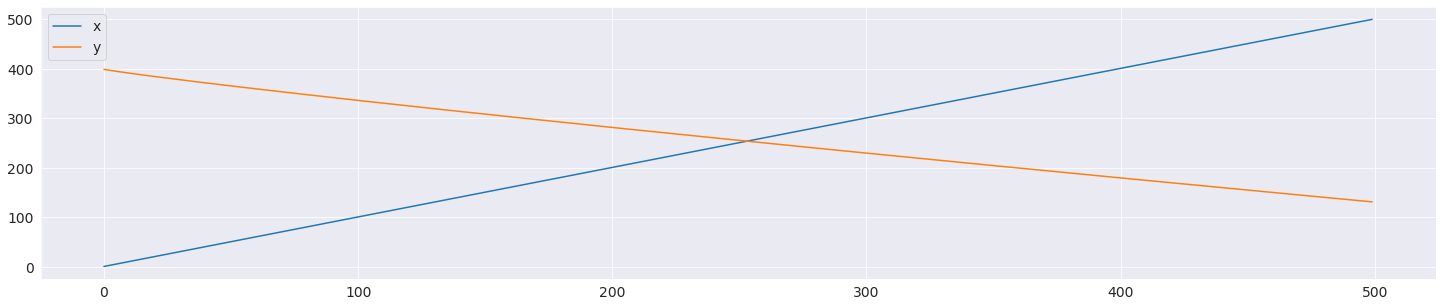

In [ ]:
length = 500
frc_ts = pd.DataFrame([[1+x, length-(1+x)**(0.9)-100] for x in range(length)], columns = ['x','y'])
frc_ts.plot()

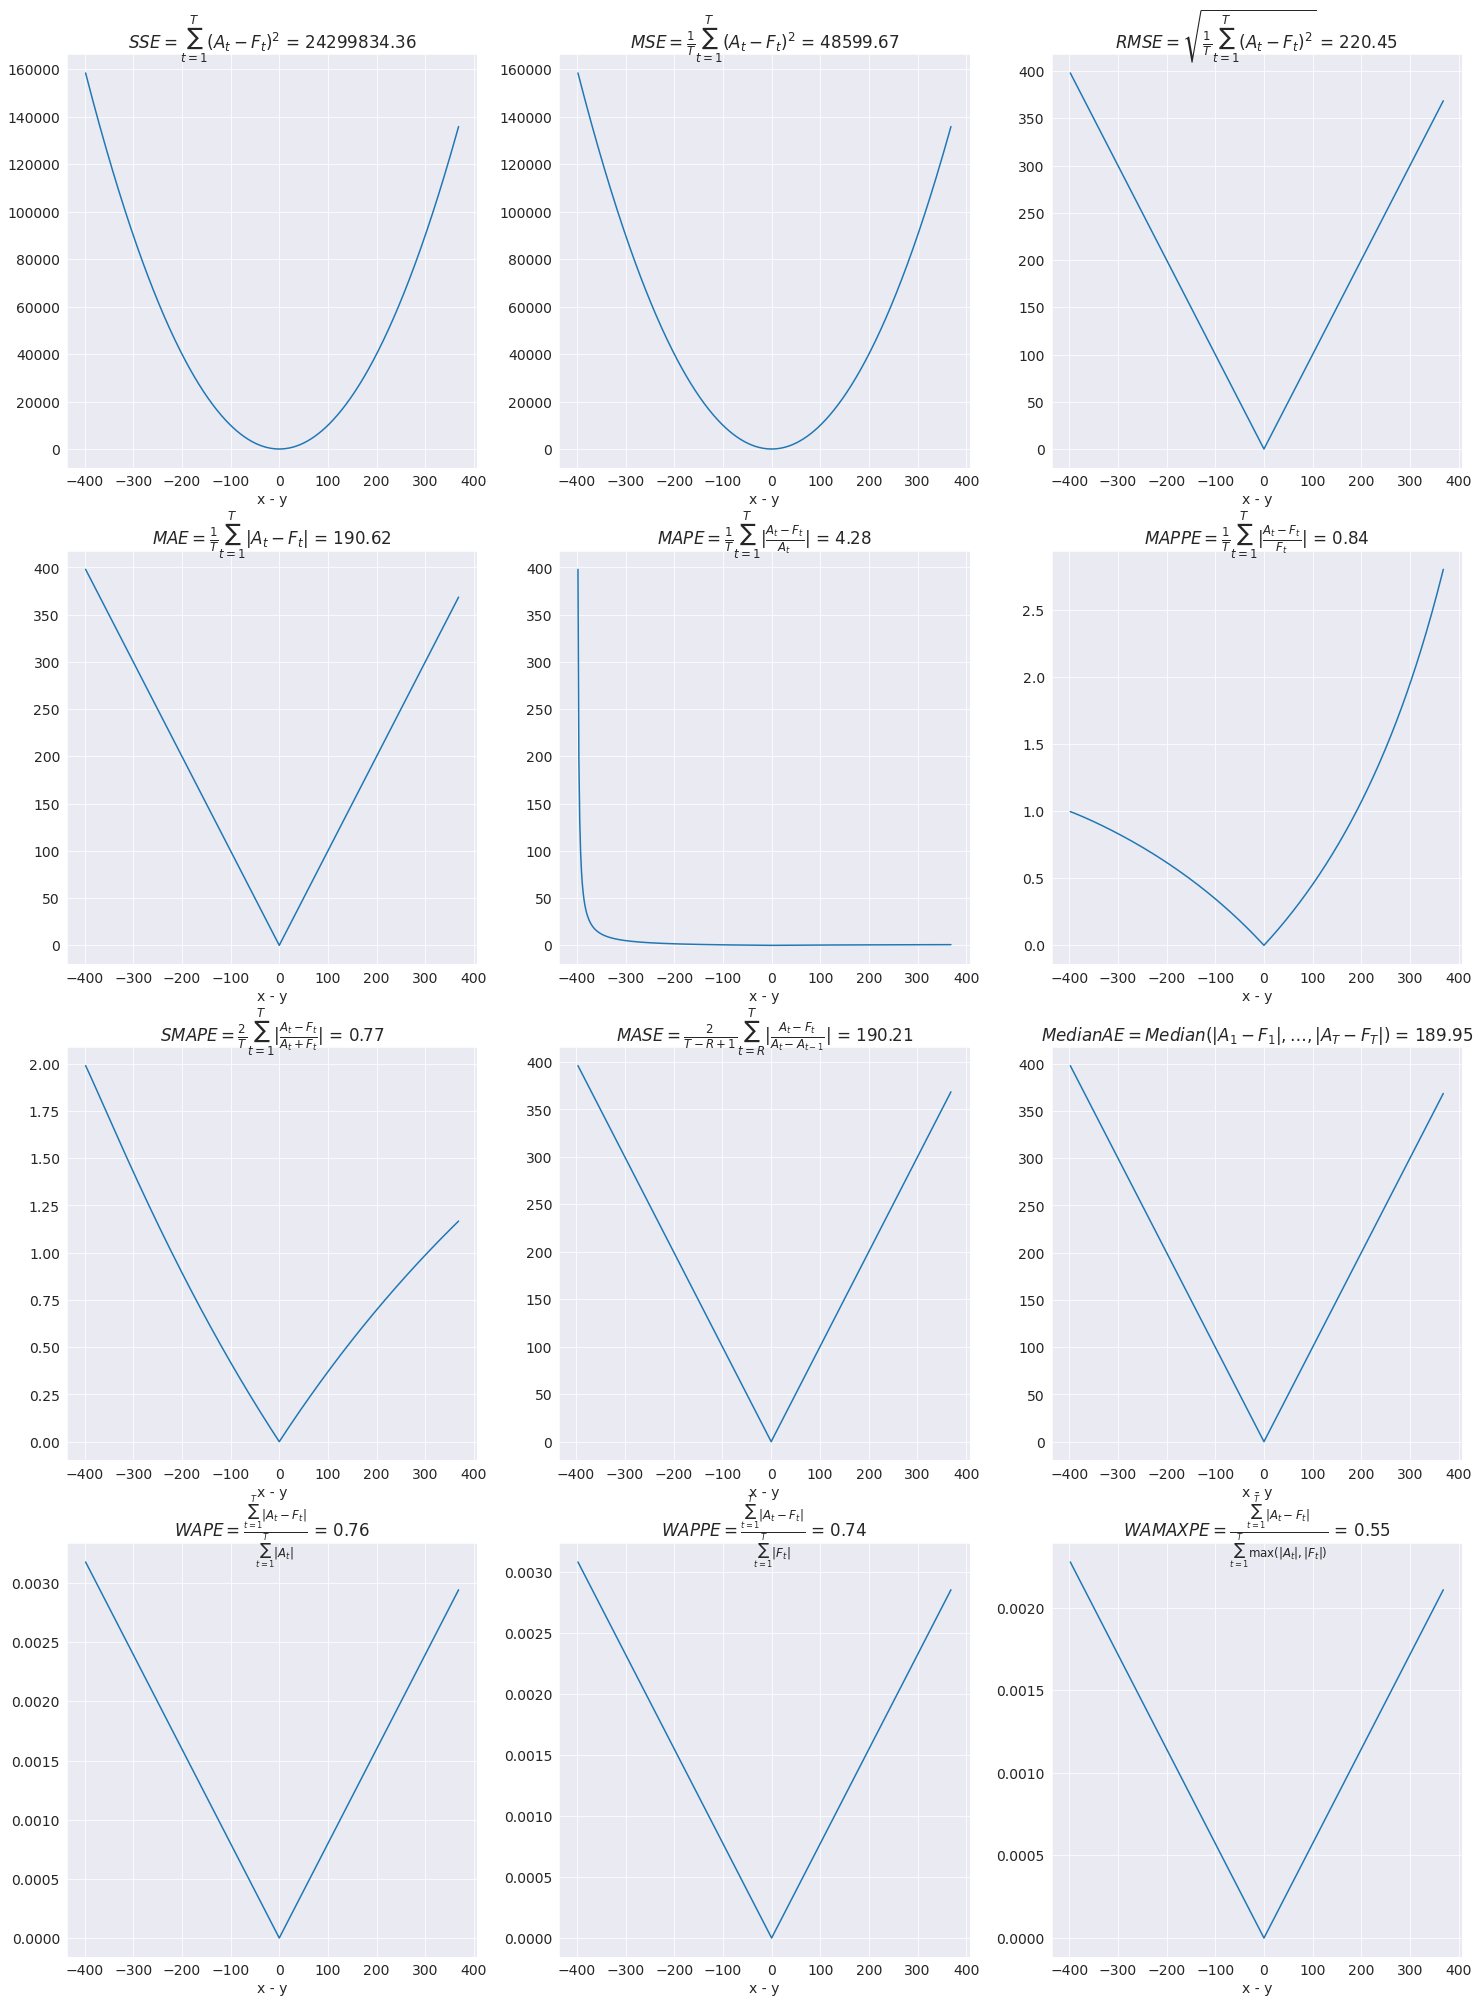

In [ ]:
qlt_desc = [r"$SSE =\sum_{t=1}^T  \left({A_t-F_t}\right)^2 $",
r"$MSE =\frac{1}{T}\sum_{t=1}^T  \left({A_t-F_t}\right)^2 $",
r"$RMSE =\sqrt{\frac{1}{T}\sum_{t=1}^T  \left({A_t-F_t}\right)^2} $",
r"$MAE =\frac{1}{T}\sum_{t=1}^T  \left|{A_t-F_t}\right| $",
r"$MAPE =\frac{1}{T}\sum_{t=1}^T  \left|\frac{A_t-F_t}{A_t}\right| $",
r"$MAPPE =\frac{1}{T}\sum_{t=1}^T  \left|\frac{A_t-F_t}{F_t}\right| $",
r"$SMAPE =\frac{2}{T}\sum_{t=1}^T  \left|\frac{A_t-F_t}{A_t+F_t}\right| $",
r"$MASE = \frac{2}{T-R+1} \sum_{t=R}^T \left|\frac{A_t-F_t}{A_t-A_{t-1}}\right| $",
r"$MedianAE = Median \left(\left|A_1-F_1\right|,\dots,\left|A_T-F_T\right|\right) $",
r"$WAPE =\frac{\sum_{t=1}^T\left|A_t-F_t\right|}{\sum_{t=1}^T\left|A_t\right|} $",
r"$WAPPE =\frac{\sum_{t=1}^T\left|A_t-F_t\right|}{\sum_{t=1}^T\left|F_t\right|} $",
r"$WAMAXPE =\frac{\sum_{t=1}^T\left|A_t-F_t\right|}{\sum_{t=1}^T\max(\left|A_t\right|,\left|F_t\right| )} $"]

fig = plt.figure(figsize = (25,35))
ax1=fig.add_subplot(111)
qlt_array=['SSE', 'MSE', 'RMSE', 'MAE', 'MAPE', 'MAPPE', 'SMAPE', 'MASE', 'MedianAE', 'WAPE', 'WAPPE', 'WAMAXPE']
qlt = [np.NaN]*len(qlt_array)
for i in range(len(qlt_array)):
    plt.subplot(4,3,i+1)
    qlt[i], qlt_vec = eval('quality'+qlt_array[i])(frc_ts['x'], frc_ts['y'])
    qlt_vec.index = frc_ts['x']-frc_ts['y']
    qlt_vec.plot(xlabel = 'x - y',  title = '{0} = {1}'.format(qlt_desc[i], round(qlt[i],2)))
    # plt.title(qlt_array[i], y=0.9)

**Let's consider random signal $y_t: {\bf{E}}(y_t, y_{t+\tau}) = 0, \forall \tau>0$**.

Optimal forecast:
$$\hat y^* = \arg\min_{\hat y}\left(\int_{-\infty}^{+\infty}Loss(y, \hat y)\cdot~p(y) dy\right)$$

**Questions**:
  * What is the optimal forecast for prediction of such $y_t$?
  * What is the optimal forecast for prediction of such $y_t$ w.r.t. SSE loss function?
  
  $\hat y^* = {\mathbf E}y$

  * What is the optimal forecast for prediction of such $y_t$ w.r.t. MAE loss function?

  $\hat y^* = F^{-1}(0.5)~-$ median

  * What is the optimal forecast for prediction of such $y_t$ w.r.t. MAPE/MAPPE/WAPE/WAPPE/WAMAXPE loss functions?


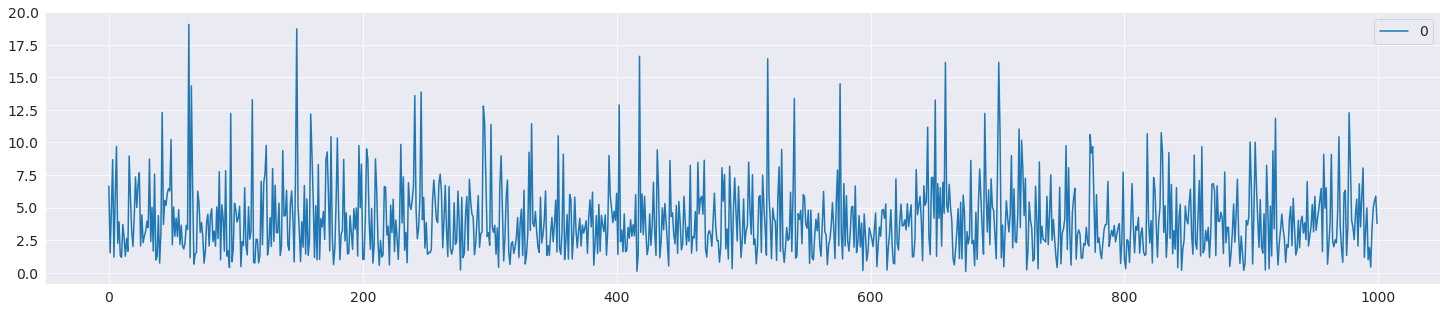

In [ ]:
# generate random variable
shape, scale = 2., 2.  # mean=2, std=2*sqrt(2)
y = np.random.gamma(shape, scale, 1000)
pd.DataFrame(y).plot()

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fd5062b4550>]],
      dtype=object)

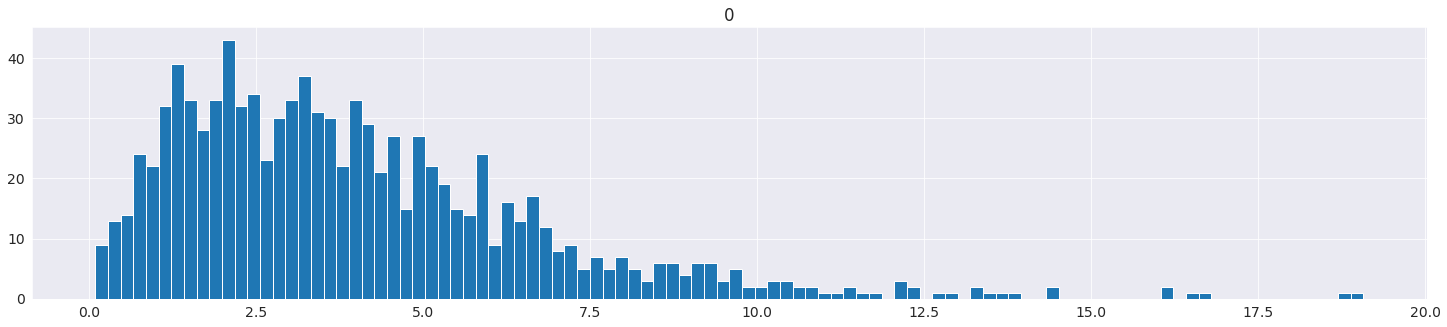

In [ ]:
# plot histogramm
pd.DataFrame(y).hist(bins = 100)

In [ ]:
# self-practice task: realize search for optimal value wrt to all loss functions above
[put your code here]

# Internal Functional for Regression TS Models

## ML approach to the problem (reminder)

* Definitions
  * $X$ --- feature space ($\mathbb R^n$);
  * $Y$ --- answer space ($\mathbb R$);
  * $X^\ell = (x_i,y_i)_{i=1}^\ell~-$ train samples;
  * $y_i=y(x_i)$,$~y\colon X\to Y~-$ unknown function;

  * assumption: there is joint distribution $p(x,y)$ for samples from $X^\ell$
  * loss function $\lambda(y_i, \hat y_i): \mathbb R\times \mathbb R\rightarrow [0,+\infty) $

* Learning method is a function: $\mu\colon 2^{X\times Y}\rightarrow \mathfrak{A}$

* loss of algorithm $A=\mu(X^\ell)$:
$$  {Loss}_A = {\mathbf E}_{x,y}\left[ \lambda\left(y, \mu\left(X^\ell\right)\right)\right]$$
  * Estimation of algorithm loss $A=\mu(X^\ell)$

$$ Loss_{A}(X^\ell)=\sum_{i=1}^\ell \lambda\left(y_i, A(x_i)\right) $$

* loss of learning method $\mu$:
$$ {Q}_\mu={\mathbf E}_{X^\ell}\left[Loss_{A} \right] $$

* <font color="red">Main problem of ML is to minimize ${Q}_\mu$</font>

**Question:**
  * Which approaches do you know to calculate ${Q}_\mu$?
<br></br>
<br></br>

## Estimation of $Q_\mu$ using CV

* Hold-out CV: split all data to two sets: $X^\ell=X^{Train}\bigcup X^{Validation}$
<img src = "https://algotrading101.com/learn/wp-content/uploads/2020/06/training-validation-test-data-set.png">


$$ Q_\mu^{CV} (X^\ell) = Q\left(\mu(X^L),X^K\right) = Loss_{\mu(X^L)}\left(X^{K} \right)
$$

**Question**: why testing sample is needed?

<br></br>
* q-fold CV: $X^\ell=X_1^{\ell_1}\bigcup\dots\bigcup X_q^{\ell_q}$

<img src = "https://sebastianraschka.com/images/faq/evaluate-a-model/nested-k-fold.png">
$$
            \mathrm{Q_\mu^{q-fold}}(X^\ell)
            =\frac{1}{q}
            \sum_{i=1}^q
                Q \bigl(\mu \left(X^\ell\!\setminus\!\!\{X^{\ell_i}_i\}\right), X^{\ell_i}_i \bigr)
$$



## Estimation of $Q_\mu$ in case of Linear Regression
* Let's assume that 
$$\mu(X^\ell)(x_i) = A(x_i) = f_1(x_i)\cdot w_1 + \dots + f_\color{red}d (x_i)\cdot w_\color{red}d$$

* Calculate loss of the learning algorithm on the whole $X^\ell$

$$Q \bigl(\mu \left(X^\ell\right), X^{\ell} \bigr) =\log\left(\frac{1}{\ell}{\sum_{i=1}^\ell \left(\mu(X^\ell)(x_i) - y_i\right)^2}\right)$$

<!-- i.e. just log(MSE) -->

<table border="0">
 <tr>
    <td><style="font-size:30px">
      Criterion
    </td>
    <td>
      $~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~$ML Equivalence Formula$~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~$
    </td>
    <td>
      $~~~~~~$Pro
    </td>
</tr>
<tr>
    <td>
AIC (Akaike Information Criterion)
    </td>
    <td>  
      $$Q_\mu^{AIC}(X^\ell) = Q \bigl(\mu \left(X^\ell\right), X^{\ell} \bigr)+ \frac{2\cdot d }{\ell}$$
    </td>
    <td>
  - model has unknown high dimensional reality
  <br></br>
  - asymptotically efficient (is good for making asymptotically equivalent to cross-validation)
    </td>
</tr>
<tr>
</td>
    <td>
BIC (Bayes Information Criterion)
</td>
    <td>
$$Q_\mu^{BIC}(X^\ell) =  Q \bigl(\mu \left(X^\ell\right), X^{\ell} \bigr) + \frac{\ln(\ell)\cdot d}{\ell}$$
</td>
    <td>
     - penalizes free parameters more strongly than AIC
     <br></br>
     - is consistent
</tr>
<tr>
  <td>
HQIC (Hannan–Quinn information criterion)
</td>
    <td>
    $$Q_\mu^{HQIC}(X^\ell) = Q \bigl(\mu \left(X^\ell\right), X^{\ell} \bigr) + \frac{\ln\ln(\ell)\cdot d}{\ell}$$
  </td>
  <td>
     - is consistent
     <br></br>
     - asymptotically very well-behaved
  </td>
</tr>
</table>


# Selecting the Best Time Series Forecasting Algorithm


**Two-steps CV approach** 
<img src = "https://miro.medium.com/max/1400/1*OsY2PjdFJOIsQj9E5S34cQ.png">

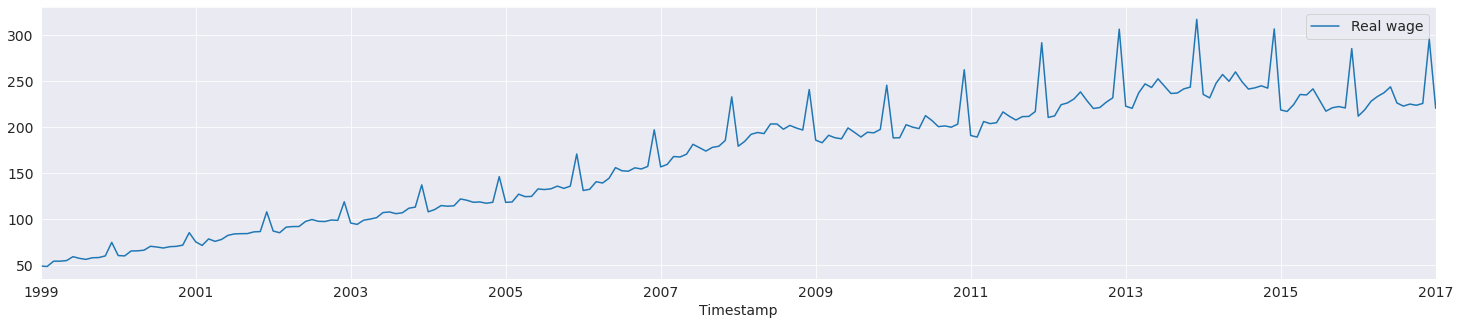

In [194]:
# Wage
ts_wage = pd.read_csv('https://raw.githubusercontent.com/aromanenko/ATSF/33b78c9be63831567f8036ad40c5859e824d30f7/data/monthly-wage.csv', sep=';', decimal='.', parse_dates=True, index_col='Month')
ts_wage.index.names=['Timestamp']
ts_wage = ts_wage['01-01-1999':]
ts_wage.plot()

In [195]:
test_period_start = '2016-01-01'
test_period_end = '2018-01-01'
loss = 'SMAPE'

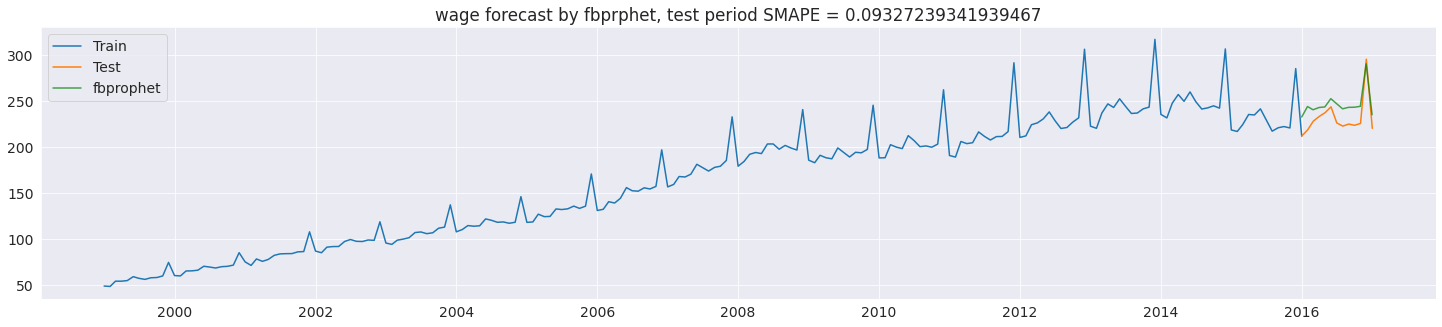

In [196]:
# forecasting with FBPropheta
from fbprophet import Prophet
#suppressing the info logs
import logging
logging.getLogger('fbprophet').setLevel(logging.ERROR)

#creating a dataframe that fbprophet requires
# df = pd.DataFrame([col])
# df['ds'] = df.index
# df.columns = ['y', 'ds']
    
#making predictions
m = Prophet()
m.fit(ts_wage[:test_period_start].reset_index().rename(columns={'Real wage':'y', 'Timestamp':'ds'}))
#'make_future_dataframe' parameter decides how far into the future we're looking
future = m.make_future_dataframe(12,freq = 'M')
forecast = m.predict(future)

test_loss = eval('quality' + loss)(ts_wage.loc[test_period_start:test_period_end, 'Real wage'], forecast.set_index('ds').loc[test_period_start:test_period_end, 'yhat'])[0]

#plotting the results
plt.figure()
plt.plot(ts_wage.loc[:test_period_start].index, ts_wage.loc[:test_period_start], label='Train')
plt.plot(ts_wage.loc[test_period_start:].index, ts_wage.loc[test_period_start:, 'Real wage'], label='Test')
plt.plot(forecast.set_index('ds').loc[test_period_start:].index, forecast.set_index('ds').loc[test_period_start:,'yhat'], color='green', alpha=0.7, label='fbprophet')
plt.title('wage forecast by fbprphet, test period {0} = {1}'.format(loss, eval('quality' + loss)(ts_wage.loc[test_period_start:test_period_end, 'Real wage'], forecast.set_index('ds').loc[test_period_start:test_period_end, 'yhat'])[0]))
plt.legend()

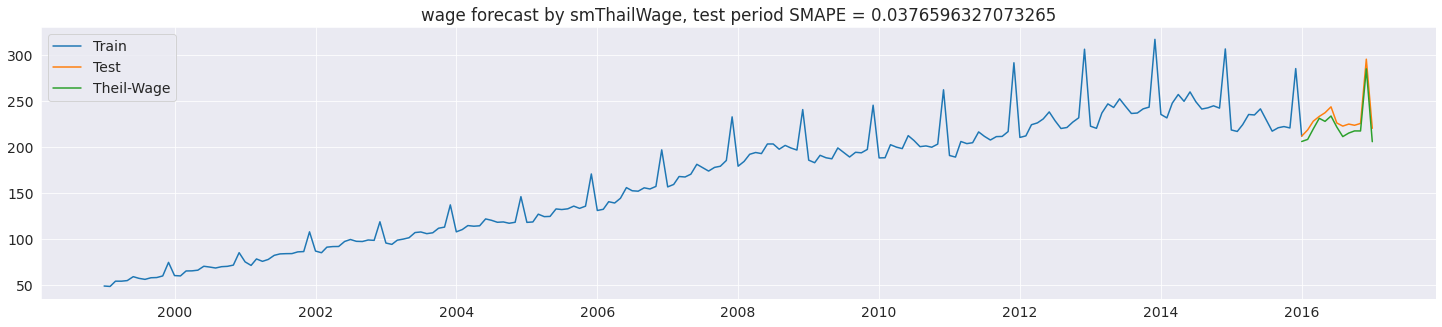

In [ ]:
# statmodels TW
from statsmodels.tsa.holtwinters import ExponentialSmoothing

train, test = ts_wage.loc[:test_period_start, 'Real wage'], ts_wage.loc[test_period_start:, 'Real wage']
model = ExponentialSmoothing(train, trend = 'add', seasonal='add', seasonal_periods=12).fit()
twpred = model.predict(start=test.index[0], end=test.index[-1])

plt.plot(train.index, train, label='Train')
plt.plot(test.index, test, label='Test')
plt.plot(twpred.index, twpred, label='Theil-Wage')
plt.title('wage forecast by smThailWage, test period {0} = {1}'.format(loss, eval('quality' + loss)(test, twpred)[0]))
plt.legend(loc='best')


In [ ]:
# statmodels SARIMAX
def fit_arima_12(ts, p,d,q,P,D,Q, exogs_var = None): 
    try:
        mod = sm.tsa.statespace.SARIMAX(endog = ts, order=(p,d,q), seasonal_order=(P,D,Q,12), exog = exogs_var)
        results = mod.fit()
        return("sarimax_%i%i%i_%i%i%i: aic=%f, bic=%f, hqic=%f " % (p,d,q,P,D,Q, 
               results.aic, results.bic, results.hqic))
    except Exception:
        return ("sarimax_%i%i%i_%i%i%i: can't fit model " % (p,d,q,P,D,Q)) 


# Qaution: we assume that the appropriate d = 1, D = 1
# try most popular parameters of ARIMA
from sklearn.model_selection import ParameterGrid

param_grid = {'p': [0, 1], 'd' : [1],
             'q': [0, 1], 'P' : [0, 1],
             'D': [1], 'Q' : [0,1]}

grid = ParameterGrid(param_grid)

for params in grid:
    print(fit_arima_12(ts_wage.loc[:test_period_start, 'Real wage'],params['p'], params['d'], params['q'], params['P'], params['D'], params['Q']))

sarimax_010_010: aic=1076.110259, bic=1079.367754, hqic=1077.429569 
sarimax_011_010: aic=1071.458680, bic=1077.973671, hqic=1074.097299 
sarimax_110_010: aic=1071.034689, bic=1077.549679, hqic=1073.673308 
sarimax_111_010: aic=1073.019611, bic=1082.792097, hqic=1076.977540 
sarimax_010_011: aic=1077.986771, bic=1084.501761, hqic=1080.625390 
sarimax_011_011: aic=1073.362833, bic=1083.135319, hqic=1077.320762 
sarimax_110_011: aic=1072.960699, bic=1082.733186, hqic=1076.918628 
sarimax_111_011: aic=1074.955882, bic=1087.985863, hqic=1080.233120 
sarimax_010_110: aic=1077.949908, bic=1084.464898, hqic=1080.588527 
sarimax_011_110: aic=1073.331118, bic=1083.103604, hqic=1077.289047 
sarimax_110_110: aic=1072.937026, bic=1082.709512, hqic=1076.894955 
sarimax_111_110: aic=1074.934342, bic=1087.964323, hqic=1080.211580 
sarimax_010_111: aic=1074.926260, bic=1084.698746, hqic=1078.884189 
sarimax_011_111: aic=1071.901608, bic=1084.931589, hqic=1077.178846 
sarimax_110_111: aic=1071.424301, 

In [198]:
arima_frc

2016-02-01    207.327661
2016-03-01    215.292752
2016-04-01    226.181579
2016-05-01    225.703450
2016-06-01    232.299147
2016-07-01    220.299994
2016-08-01    208.099827
2016-09-01    211.799860
2016-10-01    213.099854
2016-11-01    211.599855
2016-12-01    275.999855
2017-01-01    202.699855
Freq: MS, dtype: float64

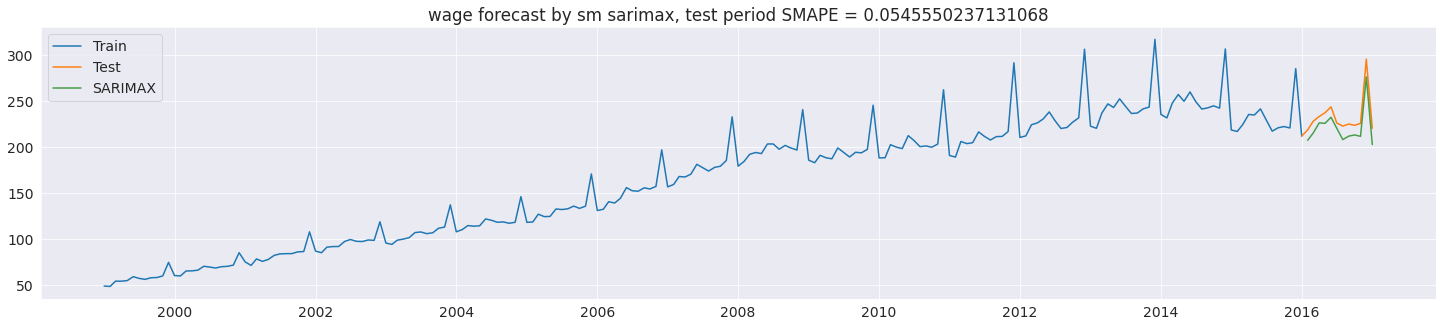

In [199]:
sarimax_110_010 = sm.tsa.statespace.SARIMAX(endog= ts_wage.loc[:test_period_start, 'Real wage'], trend='n', 
                                            order=(1,1,0), seasonal_order=(0,1,0,12)).fit()
arima_frc =sarimax_110_010.forecast(steps = 12)

#plotting the results
plt.figure()
plt.plot(ts_wage.loc[:test_period_start].index, ts_wage.loc[:test_period_start], label='Train')
plt.plot(ts_wage.loc[test_period_start:].index, ts_wage.loc[test_period_start:, 'Real wage'], label='Test')
plt.plot(arima_frc.loc[test_period_start:].index, arima_frc.loc[test_period_start:], color='green', alpha=0.7, label='SARIMAX')
plt.title('wage forecast by sm sarimax, test period {0} = {1}'.format(loss, eval('quality' + loss)(ts_wage.loc[test_period_start:test_period_end, 'Real wage'], arima_frc.loc[test_period_start:test_period_end])[0]))
plt.legend()

**Questions** 
  * Which models should be selected as the best for the wage ts?

# Conclusion
## Self-check questions
  1. Forecast value highly depends on loss function
  2. AIC, BIC, HQIC suggest alternative approach to estimate loss of learing method

<!-- 3. 
  4. ?
  5. ?
    -->


**Materialsf**
* Hyndman R.J., Athanasopoulos G. Forecasting: principles and practice,2016. https://www.otexts.org/book/fpp
* Difference Between AIC and BIC | Difference Between http://www.differencebetween.net/miscellaneous/difference-between-aic-and-bic/#ixzz79MzuB0pt
* AIC, BIC derivation http://faculty.washington.edu/yenchic/19A_stat535/Lec7_model.pdf